In [1]:
import pandas as pd
import numpy as np
from keras.datasets import boston_housing
from keras import models, layers, optimizers
import matplotlib.pyplot as plt

In [2]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()
train_data.shape, test_data.shape, train_targets.shape, test_targets.shape

((404, 13), (102, 13), (404,), (102,))

In [3]:
train_targets[0]

15.2

In [4]:
train_data[0]

array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
        18.72   ])

In [5]:
# Z-score normalization

mean = train_data.mean(axis=0)
train_data = train_data - mean

std = train_data.std(axis=0)
train_data /= std

test_data = test_data - mean # Todas las operaciones se hacen con los datos de entrenamiento, jamás con los de test
test_data /= std

In [7]:
# model = models.Sequential()
# model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(1)) # No hay activación porque es una regresión lineal

In [48]:
def build_model(learning_rate: float = 0.001, input_shape = 13) -> models.Sequential:
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(input_shape,)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1)) # No hay activación porque es una regresión lineal

    model.compile(optimizer=optimizers.RMSprop(learning_rate=learning_rate), loss='mse', metrics=['mae'])

    return model

In [49]:
# K-fold validation
k = 4
num_val_samples = len(train_data) // k
num_epochs = 85
all_history = []

In [50]:
for i in range(k):
    print(f'Processing fold #{i}')

    val_data = train_data[i * num_val_samples : (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [train_data[ : i * num_val_samples], train_data[(i + 1) * num_val_samples :]],
        axis=0
    )

    partial_train_targets = np.concatenate(
        [train_targets[: i * num_val_samples], train_targets[(i + 1) * num_val_samples :]],
        axis=0
    )

    model = build_model()
    history = model.fit(partial_train_data, 
                        partial_train_targets, 
                        epochs=num_epochs, 
                        batch_size=16, 
                        validation_data=(val_data, val_targets),
                        verbose=0)
    
    all_history.append(history.history['val_mae'])

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [51]:
len(all_history[0]) # 80 epochs

85

In [52]:
all_mae_avg = pd.DataFrame(all_history).mean(axis=0)

In [53]:
all_mae_avg

0     19.299835
1     15.742535
2     11.453981
3      7.479602
4      5.506961
        ...    
80     2.385437
81     2.443679
82     2.441550
83     2.390998
84     2.386180
Length: 85, dtype: float64

In [54]:
len(all_mae_avg)

85

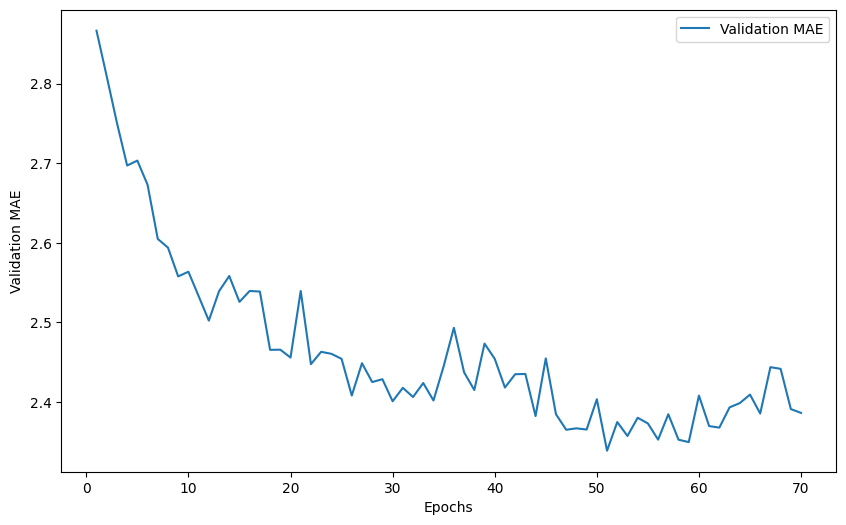

In [55]:
plt.figure(figsize=(10, 6))

plt.plot(
    range(1, len(all_mae_avg[15:]) + 1),
    all_mae_avg[15:],
    # 'b',
    label='Validation MAE'
)

plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.legend()

plt.show()

In [56]:
model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 3ms/step - loss: 20.7495 - mae: 3.0800


[20.74945831298828, 3.080014944076538]

## K fold con sklearn

In [57]:
from sklearn.model_selection import KFold

In [58]:
model = build_model()

kfold = KFold(n_splits=4, shuffle=True)

In [59]:
all_history = []

for train_idx, val_idx in kfold.split(train_data):
    x_train, y_train = train_data[train_idx], train_targets[train_idx]
    x_val, y_val = train_data[val_idx], train_targets[val_idx]

    history = model.fit(x_train, y_train, epochs=85, batch_size=16, validation_data=(x_val, y_val), verbose=0)

    all_history.append(history.history['val_mae'])

In [60]:
all_mae_avg = pd.DataFrame(all_history).mean(axis=0)

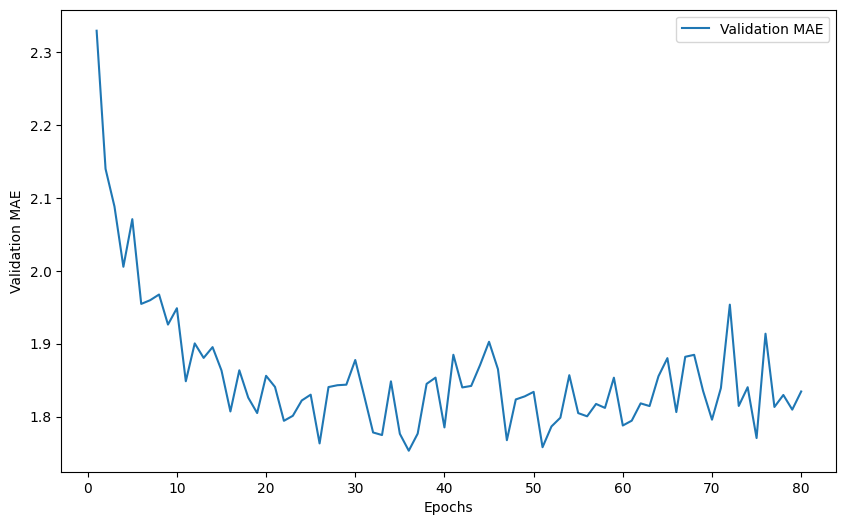

In [63]:
plt.figure(figsize=(10, 6))

plt.plot(
    range(1, len(all_mae_avg[5:]) + 1),
    all_mae_avg[5:],
    # 'b',
    label='Validation MAE'
)

plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.legend()

plt.show()

In [64]:
model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 8ms/step - loss: 14.5544 - mae: 2.5040


[14.554405212402344, 2.5039665699005127]

In [65]:
predictions = model.predict(test_data)

4/4 [==============================] - 1s 2ms/step


In [66]:
predictions[0]

array([9.053507], dtype=float32)

In [67]:
test_targets[0]

7.2